Import packages

In [73]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import os
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

Download NLTK resources

In [76]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacksongeorge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jacksongeorge/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacksongeorge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Human-Human Cosine Similarity

Load the flitzes

In [80]:
real_flitz_file_path = "/Users/jacksongeorge/Desktop/real_flitzes.xlsx"
real_flitz_df = pd.read_excel(real_flitz_file_path, header=None)

# Keep first column as text, drop empty rows, coerce to str
flitz_texts = (
    real_flitz_df.iloc[:, 0]
    .dropna()
    .astype(str)
    .str.strip()
    .tolist()
)

n = len(flitz_texts)
labels = [str(i) for i in range(1, n + 1)]  # "1".."33"

print(f"Loaded {n} flitzes.")

Loaded 33 flitzes.


TF-IDF Vectorization & Cosine Similarity

In [83]:
# Pairwise cosine similarity
cosine_mat = np.zeros((n, n), dtype=float)

for i in range(n):
    ti = flitz_texts[i]
    for j in range(i, n):
        tj = flitz_texts[j]

        vectorizer = TfidfVectorizer()
        tfidf = vectorizer.fit_transform([ti, tj])

        # If both ended up empty, cosine is undefined -> set to 0
        if tfidf.shape[1] == 0:
            score = 0.0
        else:
            score = cosine_similarity(tfidf[0], tfidf[1])[0, 0]

        cosine_mat[i, j] = score
        cosine_mat[j, i] = score

# DataFrame with simple labels 1..n
cosine_df = pd.DataFrame(cosine_mat, index=labels, columns=labels)

Plot heatmap

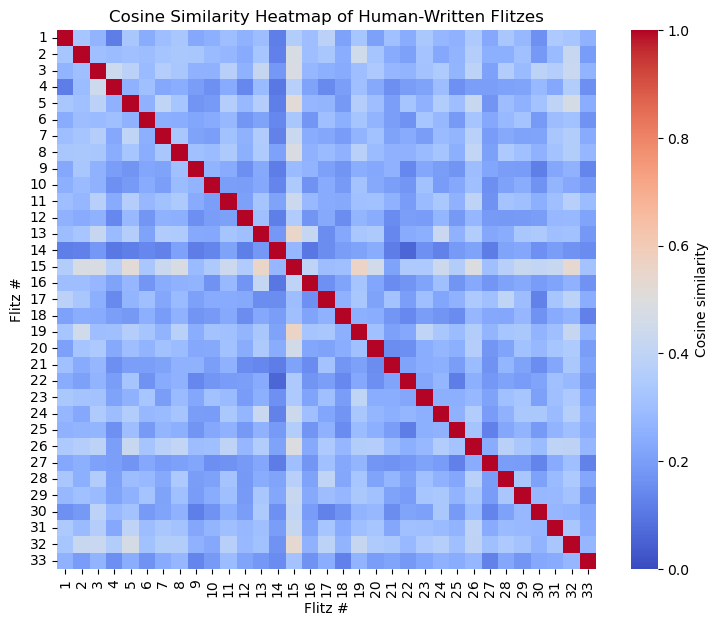

In [94]:
plt.figure(figsize=(9, 7))
sns.heatmap(
    cosine_df,
    cmap="coolwarm",
    vmin=0, vmax=1,
    square=True,
    cbar_kws={"label": "Cosine similarity"},
    xticklabels=True, yticklabels=True
)
plt.title("Cosine Similarity Heatmap of Human-Written Flitzes")
plt.xlabel("Flitz #")
plt.ylabel("Flitz #")
plt.tight_layout

# Save to Desktop
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
file_path = os.path.join(desktop_path, "human_human_cosine.png")
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

## AI-AI Cosine Similarity

In [89]:
ai_flitz_directory = "/Users/jacksongeorge/Desktop/ai_flitz_samples"
file_list = os.listdir(ai_flitz_directory)

# Example file: temp_0.00_sample_01.xlsx
pattern = r"temp_(\d+\.\d{2})_sample_(\d+)\.xlsx"

SAMPLES_PER_TEMP = 5
RANDOM_SEED = None
MAX_ATTEMPTS_PER_PICK = 30  # retry limit

if RANDOM_SEED is not None:
    random.seed(RANDOM_SEED)

# --- Index files by temperature -> {sample_number: filepath} ---
temp_to_samplepath = {}
for fname in file_list:
    m = re.match(pattern, fname)
    if not m:
        continue
    temp_str = m.group(1)                    # e.g., "0.00"
    sample_num = int(m.group(2))             # 1..10
    temp_to_samplepath.setdefault(temp_str, {})[sample_num] = os.path.join(ai_flitz_directory, fname)

temps_sorted = sorted(temp_to_samplepath.keys(), key=lambda s: float(s))
print(f"Found temperatures: {temps_sorted}")

Found temperatures: ['0.00', '0.13', '0.25', '0.38', '0.50', '0.63', '0.75', '0.88', '1.00', '1.13', '1.25', '1.38', '1.50', '1.63', '1.75', '1.88', '2.00']


Compute cosine similarity and matrices

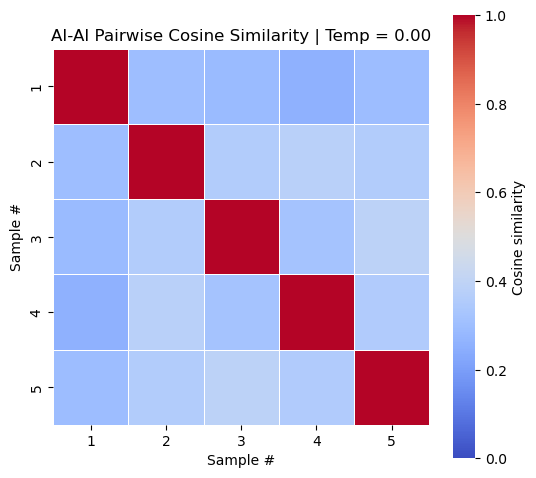

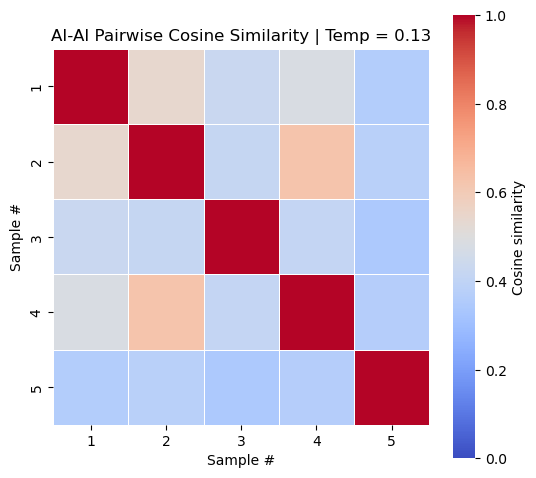

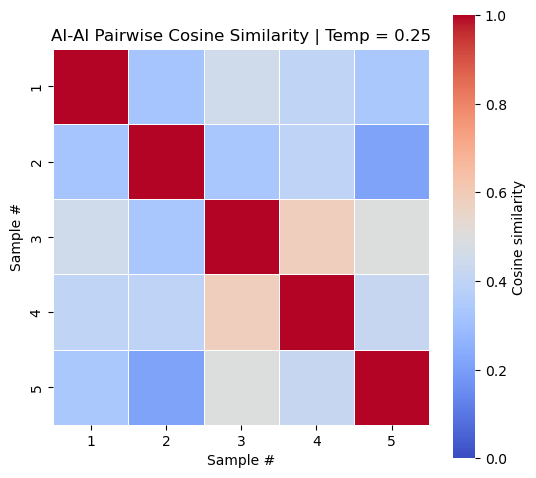

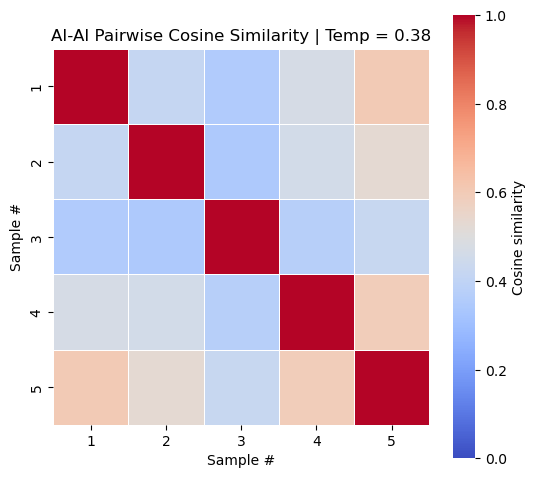

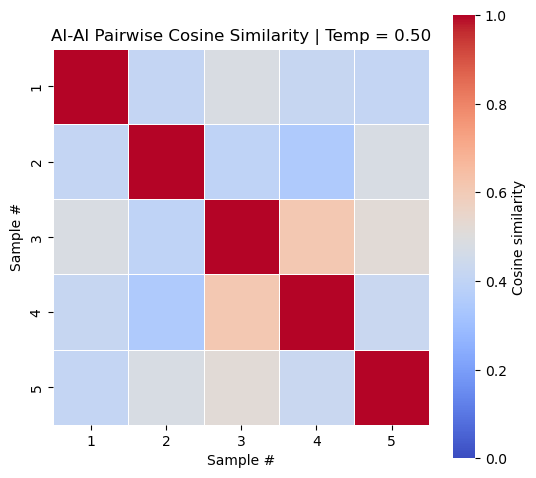

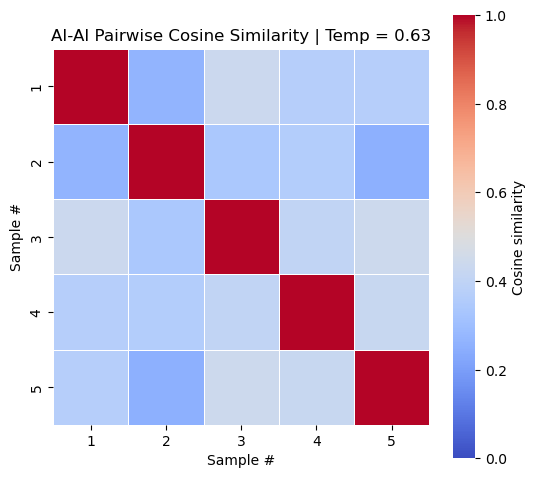

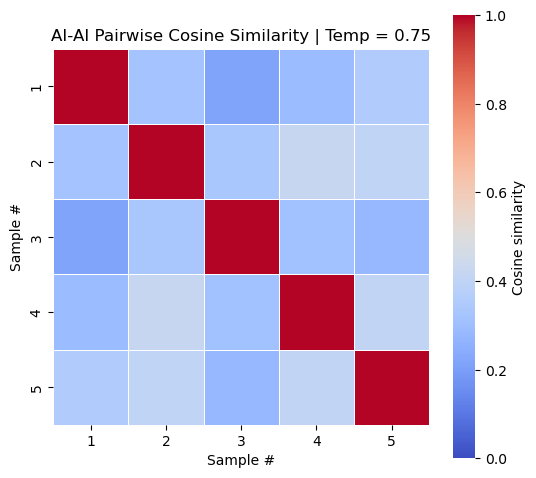

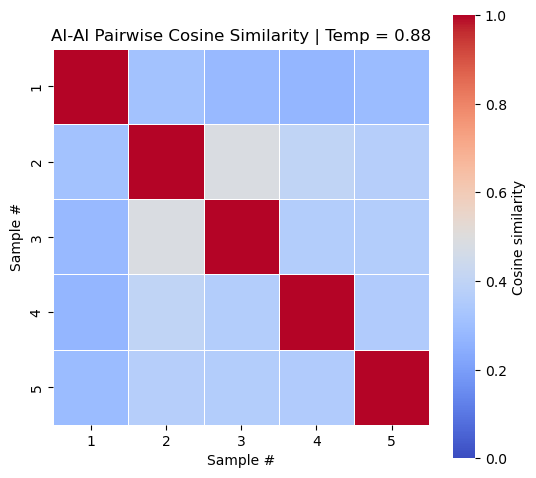

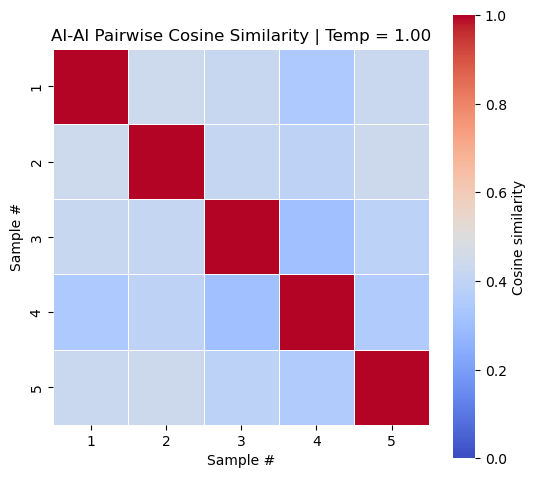

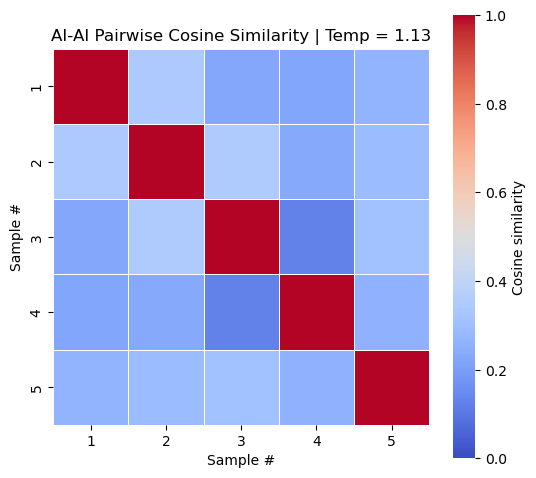

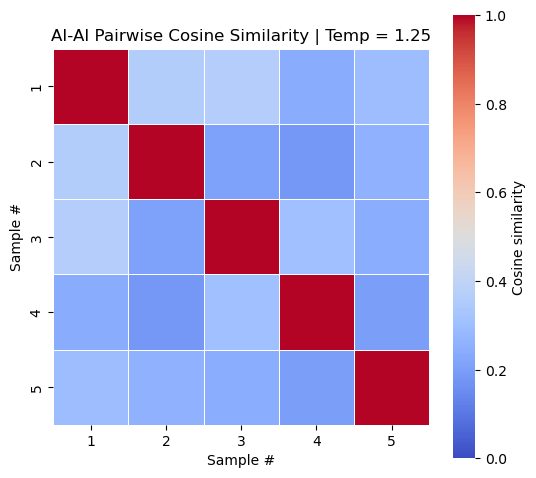

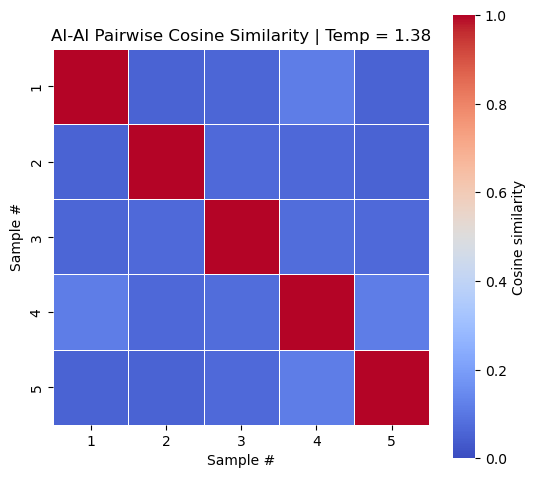

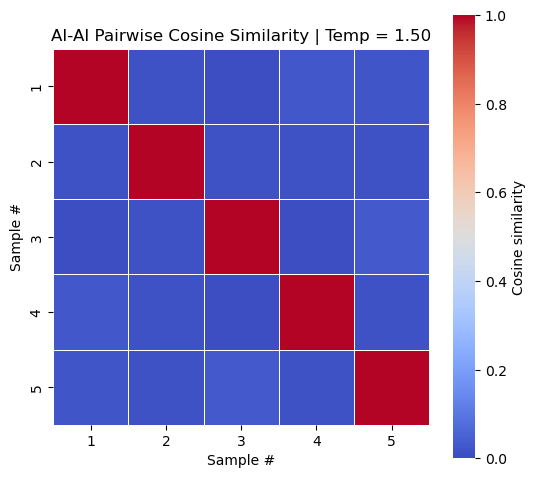

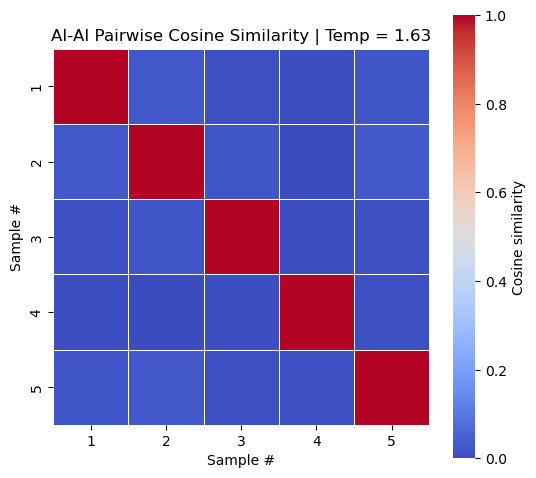

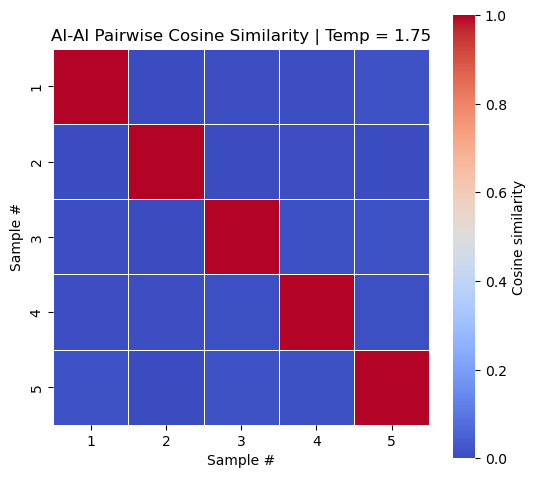

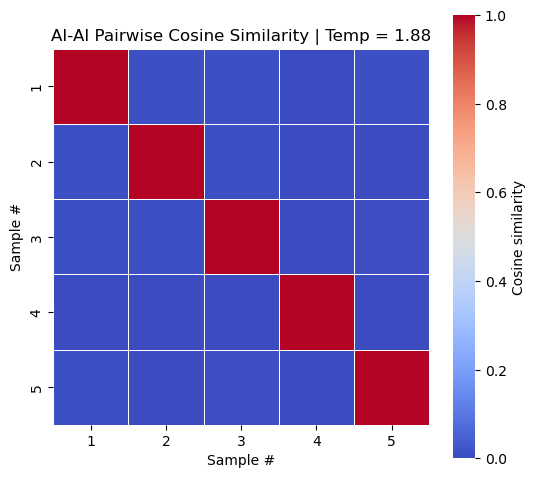

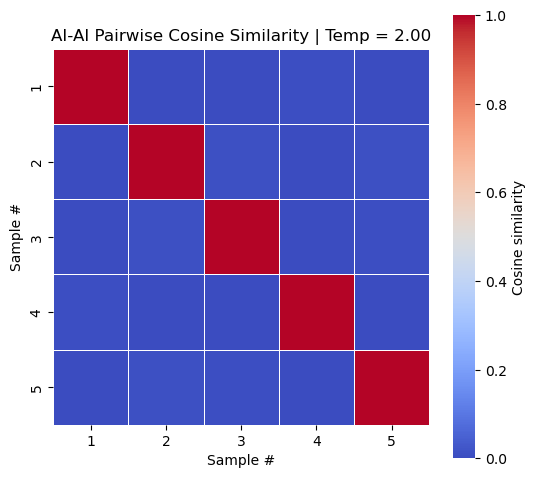

In [92]:
# Helper function: compute pairwise cosine similarity
def cosine_matrix_pairwise(texts):
    n = len(texts)
    M = np.zeros((n, n), dtype=float)
    for i in range(n):
        ti = texts[i]
        for j in range(i, n):
            tj = texts[j]
            vec = TfidfVectorizer()
            tfidf = vec.fit_transform([ti, tj])
            score = 0.0 if tfidf.shape[1] == 0 else cosine_similarity(tfidf[0], tfidf[1])[0, 0]
            M[i, j] = M[j, i] = score
    return M

for temp_str in temps_sorted:
    sample_map = temp_to_samplepath[temp_str]
    picked_texts = []
    used_pairs = set()

    for _ in range(SAMPLES_PER_TEMP):
        text = None
        for _attempt in range(MAX_ATTEMPTS_PER_PICK):
            sample_choice = random.randint(1, 10)   # pick a file
            row_choice = random.randint(0, 32)      # pick a row (0..32)

            if (sample_choice, row_choice) in used_pairs:
                continue  # already used this exact flitz

            fp = sample_map.get(sample_choice)
            if fp is None:
                continue

            try:
                df = pd.read_excel(fp)
            except Exception as e:
                print(f"⚠️ Could not read {fp}: {e}")
                continue

            col = 'Flitz Output' if 'Flitz Output' in df.columns else df.columns[0]
            if row_choice >= len(df):
                continue

            val = df.loc[row_choice, col]
            if pd.isna(val):
                continue

            s = str(val).strip()
            if not s:
                continue

            text = s
            used_pairs.add((sample_choice, row_choice))
            break

        if text is None:
            print(f"⚠️ Temp {temp_str}: failed to pick a non-empty unique flitz after retries; skipping temp.")
            picked_texts = []
            break

        picked_texts.append(text)

    if len(picked_texts) != SAMPLES_PER_TEMP:
        continue

    # Compute 5x5 cosine matrix (pairwise TF-IDF refit)
    C = cosine_matrix_pairwise(picked_texts)

    # Plot heatmap
    labels = [str(i) for i in range(1, SAMPLES_PER_TEMP + 1)]
    dfC = pd.DataFrame(C, index=labels, columns=labels)

    plt.figure(figsize=(5.5, 5))
    sns.heatmap(
        dfC, cmap="coolwarm", vmin=0, vmax=1, square=True, linewidths=0.5,
        cbar_kws={"label": "Cosine similarity"}
    )
    plt.title(f"AI-AI Pairwise Cosine Similarity | Temp = {temp_str}")
    plt.xlabel("Sample #")
    plt.ylabel("Sample #")
    plt.tight_layout()

    # Save to Desktop + show
    desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
    folder_name = "AI_AI_heatmaps"
    output_dir = os.path.join(desktop_path, folder_name)
    os.makedirs(output_dir, exist_ok=True)
    png_path = os.path.join(output_dir, f"cosine_5x5_temp_{temp_str}.png")
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    plt.show()